# Geometric Interpretation of Phasor

In [1]:
# from sympy import *
# from sympy.geometry import *
# import sympy as sp
import numpy as np
from scipy.optimize import fsolve,root,brentq,minimize
from TCSPC import *
from scipy.stats import gaussian_kde
plt.rcParams['figure.constrained_layout.use'] = True

mono exp phasor = 
$$z(a,n) = \frac{1+i(na)}{1+(na)^2}$$
where $a = \omega \tau$, fundamental angular frequency $\omega = 2\pi T/ N$, $N$ is number of bins , $T$ is period (in ns) $n$ denotes $n^{\text{th}}$ harmonic ($\omega_n = n\omega$).

Under inversion $$T(z) := \left(\frac{1}{z-1}+1\right)^*$$
mono exp phasors become:
$$T(z(a)) = \frac{i}{a}$$

For given bi-exp phasors:
$$z (a_1,a_2) = f \cdot z(a_1) + (1-f)\cdot z(a_2) $$

In [2]:
EGFP = Phasor([0.497,0.503],[2.43,3.07])
# EGFP.n_photon = int(1e5)
# EGFP.multi_exp_data()
# t,y,weights = trim_rescale_data(EGFP.t,EGFP.y2,rescale = False,r=0)
# phasor = get_phasor(y-int(EGFP.bg*EGFP.run_time/380))

### Numerical results

In [3]:
N = 19
tau =np.array([2.43,3.07] ) #lifetimes,ns
A = np.array([0.497,0.503]) #amplitudes
a1_true = EGFP.w[1]*tau[0] #mono exp phasor a
a2_true = EGFP.w[1]*tau[1]
f = A*tau/np.sum(A*tau)         #fractional intensity

def mono(n,a):
    '''Return mono-exp phasor from continuous FT
       n      nth harmonic
       a      omega*tau'''
    return (1+n*a*1j)/(1+(n*a)**2)
#p_noise = 0.0001*np.random.randn(1, 2).view(np.complex128)[0][0]
p = lambda n : f[0] * mono(n,a1_true) + f[1]*mono(n,a2_true) #add gaussian noise
#p = lambda n : EGFP.phasor[n]

def inv(z):
    '''Perform inversion on a complex number z using circle of inversion at 1 with radius 1'''
    return np.conjugate(1/(z-1)+1)

# def y(x,n):
#     '''Calculates the inverted intercept y of harmonics n for given guess inverted phasor x and bi-exp phasor p
#        Using "angles of the same sgement", angle theta between x,p,1 (centre of inversion circle) and x,y,1 are the same
#        y = tan(theta-pi/2)'''
#     theta = np.angle((x/n*1j-inv(p(n)))/(1-inv(p(n)))) #angle between x,p,1
#     return np.tan(theta-np.pi/2)

z3 = inv(EGFP.phasor)

def y_intercept(z1,z3,z2= 1):
    '''y-intercept of circle defined by z1,z2,z3,
       z1 lies on y axis (inverted mono exp component)
       z2 = 1
       z3 is the inverted bi exp phasor
       if z1.imag >z3.imag, y-intercept is below z1, hence the np.sign is used
       circle of the form z = (a+bt)/(c+dt) where t is a parameter'''
    a = z2*(z1-z3)
    b = z1*(z2-z3)
    c = z1-z3
    d = z2-z3
    centre = (a*np.conjugate(d)-b*np.conjugate(c))/(c*np.conjugate(d)-d*np.conjugate(c))
    y_sol = z1.imag-2*(z1.imag-centre.imag)
    return y_sol

def y_intercept_slope(z1,z3,alpha):
    '''intercepts of circle with line of slope -cot(alpha), given circle defined by z1,z3,and z2 =1 '''
    #rotate the set up by alpha so the line becomes y intercept
    z2 = np.exp(-alpha*1j)
    z1 *=np.exp(-alpha*1j)
    z3 *=np.exp(-alpha*1j)
    y_sol = y_intercept(z1,z3,z2) #real value only (z4 = y_sol*1j)
    return  np.exp(alpha*1j)*y_sol*1j #rotate back


def y(x,n):
    '''Return y intercept for given x (guess inverted phasor) and harmonic n'''
    z1 = x*1j/n #inverted mono
    global z3
    return y_intercept(z1,z3[n])

def x_eq(tau):
    '''In general, intercepts of a line from guess phasor to given bi-exp phasor of 
       different harmonics and the universal circle may not be related by harmonics. 
       The goal is to find x (inverted mono exp phasor) such that the inverted intercept y are related by harmonics
       inverted phasors are related by nth harmonics: x_n = x/n. The absolute value is taken for minimization purpose
       '''
    x = inv(mono(1,EGFP.w[1]*tau))
    return abs(y(x,1)/2-y(x,2))

fraction = lambda a,b,p: np.abs((p-b)/(a-b))

def generate_from_tau1_cont(tau1,phasor):
    '''Generate A1 and tau2 from continuous phasor array
       1st harmonic is used here'''
    tau2 = abs(1/y(inv(mono(1,EGFP.w[1]*tau1)),1)/EGFP.w[1])
    tau_list = sorted([tau1,tau2])
    tau1,tau2 = tau_list
    f1 = fraction(mono(1,EGFP.w[1]*tau_list[0]),mono(1,EGFP.w[1]*tau_list[1]),phasor[1])
    amp1 = EGFP.A_solve((f1,1-f1,tau1,tau2))[0]
    return np.array([amp1,*tau_list])

def cont_solve(phasor,x0 = [tau[0]]):
    global z3
    z3 = inv(phasor)
    result = minimize(x_eq,x0 = x0, bounds = [(0,1000)],method = 'cobyla') 
    tau1 = result.x[0]
    return generate_from_tau1_cont(tau1,phasor)



/var/folders/vh/bwtbn9cn1xlbm74kxlygt5b80000gn/T/ipykernel_9326/3680298097.py:19: RuntimeWarning: divide by zero encountered in divide
  return np.conjugate(1/(z-1)+1)
/var/folders/vh/bwtbn9cn1xlbm74kxlygt5b80000gn/T/ipykernel_9326/3680298097.py:19: RuntimeWarning: invalid value encountered in divide
  return np.conjugate(1/(z-1)+1)


In [4]:
cont_solve(EGFP.phasor_data[0])

array([ 1.00007301,  2.80300984, 73.26516094])

In [5]:
print('a1 inverted: ',1/a1_true)
print('a2 inverted: ', 1/a2_true)

a1 inverted:  1.2754457211176364
a2 inverted:  1.0095547564546765


In [20]:
EGFP.n_photon = int(1e9)
EGFP.repeat_sim(100)

FFT freq: 0,1,...n-1/2, -n/2,... /d*n

In [138]:
def multi_exp_DFT(omega,A,tau,dt=1/19,alpha= 2*np.pi/380):
    '''Analytic solution to Fourier Transform (normalized, i.e. divided by int_0^infty exp(-t/tau)dt) 
    of multi exponential decay with components lifetime tau
    Input:
    omega     angular frequency array
    A         amplitude array
    tau       lifetime'''
    coeff = A/(1-np.exp(-1/np.array(tau)/19))
    coeff /= np.sum(coeff) #coefficient of the sum of mono_exp_FT
    mono_arr = exp_DFT(omega,tau,dt=dt,alpha=alpha)#array of FT of each lifetime
    return np.dot(coeff,mono_arr)

In [47]:
EGFP.n_photon = int(1e9)
EGFP.repeat_sim(10)
phasor = EGFP.phasor_data[0]
N = 370 #N histogram bins
dt = 20/380
alpha = 2*np.pi/N
x = lambda tau: np.exp(-1/19/tau)
f_d = np.array([EGFP.amp[i]/(1-np.exp(-1/tau[i]/19))for i in range(2)])
f_d = f_d/np.sum(f_d)
tau = [2.43,3.07]
mono_d = lambda tau,n :(1-x(tau))/(1-x(tau)*np.exp(1j*n*alpha)) #d for discrete
mono_d_FFT = lambda tau,n: get_phasor(exp1(EGFP.t[:-10],tau))[n]
p_noise = np.random.normal(scale = 0.0000001,size = (1, 2)).view(np.complex128)[0][0]
p_d = lambda n : np.sum(f_d*np.array([mono_d(tau[0],n),mono_d(tau[1],n)])) #pure bi-exp discrete phasor
z1 = lambda tau, n : inv(mono_d(tau,n)) #0.5 * (1-1/x)*(1-1j/np.tan(alpha*n/2))
z1_FFT = lambda tau, n : inv(mono_d_FFT(tau,n)) #0.5 * (1-1/x)*(1-1j/np.tan(alpha*n/2))
z3 = inv(phasor)



def discrete_eq(tau):
    '''tau - lifetime
        z3 - bi-exp phasor'''
    return abs(y_intercept_slope(z1(tau,1),z3[1],alpha/2).real-y_intercept_slope(z1(tau,2),z3[2],alpha).real)

def discrete_eq_FFT(tau):
    '''tau - lifetime
        z3 - bi-exp phasor'''
    return abs(y_intercept_slope(z1_FFT(tau,1),z3[1],alpha/2).real-y_intercept_slope(z1_FFT(tau,2),z3[2],alpha).real)

def generate_from_tau1(tau1,phasor):
    '''Generate tau2 and amplitude from tau1'''
    tau2 = -1/np.log(1/(1-y_intercept_slope(z1(tau1,1),z3[1],alpha/2).real*2))/19 #other sol
    tau_list = sorted([tau1,tau2])
    tau1,tau2 = tau_list
    f1 = fraction(mono_d(tau_list[0],1),mono_d(tau_list[1],1),phasor[1])
    amp1 = EGFP.A_solve((f1,1-f1,tau1,tau2),discrete = True)[0]
    return np.array([amp1, *tau_list])
def discrete_solve(phasor,x0=2.4,func= discrete_eq):
    global z3
    z3 = inv(phasor)
    result_discrete = minimize(func,x0 = [x0],bounds=[(1e-5,100)],method = 'cobyla')
    tau1 = result_discrete.x[0]
    return generate_from_tau1(tau1,phasor)

In [8]:
print(EGFP.phasor_data[2][2])
print(f[0]*mono_d_FFT(2.43,2)+f[1]*mono_d_FFT(3.07,2))

(0.24806857403419588+0.4206276719403588j)
(0.24799071856647587+0.42057420093945697j)


In [38]:
corr = (1-np.exp(-370/19/2.43+1j*370/380*2*np.pi))/(1-np.exp(-370/19/2.43))
print(mono_d_FFT(2.43,2))
print(mono_d(2.43,2))
print(np.sum(exp1(EGFP.t[:-10],2.43)*np.exp(1j*EGFP.w[2]*EGFP.t[:-10]))/np.sum(exp1(EGFP.t[:-10],2.43)))
EGFP.repeat_sim(100)
print(p_d(1)/corr-EGFP.phasor_data[2][1])

(0.29675486136079277+0.44841486133628666j)
(0.2967548613607929+0.4484148613362862j)
(0.29675486136079277+0.44841486133628666j)
(3.3451584775523457e-06-3.3791983709896556e-05j)


### Difference between close-form discrete phasor and FFT

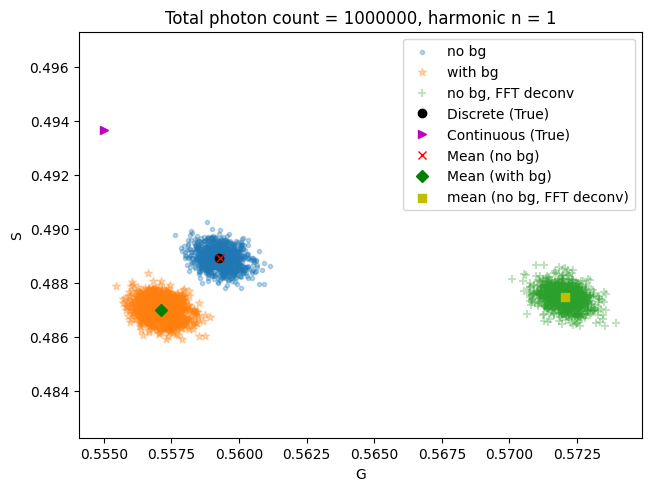

In [35]:
EGFP.n_photon = int(1e6)
EGFP.repeat_sim(1000,deconv = True)
pdata_deconv = EGFP.phasor_data
EGFP.repeat_sim(1000)
pdata = EGFP.phasor_data
pdata_bg = EGFP.phasor_data_bg
pcont = multi_exp_FT(EGFP.w[1],EGFP.amp,np.array(EGFP.tau))
pdis = multi_exp_DFT(EGFP.w[1],EGFP.amp,np.array(EGFP.tau))
plt.scatter(pdata[:,1].real,pdata[:,1].imag,alpha=0.3,marker = '.',label = 'no bg')
plt.scatter(pdata_bg[:,1].real,pdata_bg[:,1].imag,alpha= 0.3,marker = '*',label = 'with bg')
plt.scatter(pdata_deconv[:,1].real,pdata_deconv[:,1].imag,alpha=0.3,marker = '+',label = 'no bg, FFT deconv')
#plt.plot(pcont.real,pcont.imag,'o')
plt.plot(pdis.real,pdis.imag,'ko',label = 'Discrete (True)')
plt.plot(pcont.real,pcont.imag,'m>',label = 'Continuous (True)')
plt.plot(np.mean(pdata[:,1]).real,np.mean(pdata[:,1]).imag,'rx',label = 'Mean (no bg)')
plt.plot(np.mean(pdata_bg[:,1]).real,np.mean(pdata_bg[:,1]).imag,'gD',label = 'Mean (with bg)')
plt.scatter(np.mean(pdata_deconv[:,1]).real,np.mean(pdata_deconv[:,1]).imag,marker = 's',c = 'y',label = 'mean (no bg, FFT deconv)')
plt.legend()
plt.axis('equal')
plt.xlabel('G')
plt.ylabel('S')
plt.title(f'Total photon count = {EGFP.n_photon}, harmonic n = 1')
plt.savefig('fig/phasor_systematics.pdf')

In [48]:
EGFP.n_photon = int(1e10)
EGFP.repeat_sim(10)

y_pure = exp2(EGFP.t[10:],EGFP.amp[0],*EGFP.tau)
y_conv = np.convolve(exp2(EGFP.t[10:],EGFP.amp[0],*EGFP.tau),EGFP.ker,'full')[:380]
print(get_phasor(y_pure)[1]-get_phasor(y_conv[10:])[1])
print(p_d(1)-get_phasor(y_pure)[1])
print(p_d(1)-get_phasor(y_conv[10:])[1])
#

-1.1102230246251565e-16j
(0.006537896696198309-0.0009011899602990869j)
(0.006537896696198309-0.000901189960299198j)


In [51]:
EGFP.n_photon = int(1e6)
EGFP.repeat_sim(10)
discrete_solve(EGFP.phasor_data[0])

array([0.82371138, 2.60813316, 3.47212148])

In [45]:
EGFP.A_solve((0.44252875, 1-0.44252875,2.43193828, 3.07162708))

array([0.50009177, 0.49990823])

In [52]:
N_i = 20
N_j = 100
n_photon_arr = np.logspace(4,9,N_i).astype(int)
sol_array = np.zeros((N_i,N_j,3))
sol_bg_array = np.zeros((N_i,N_j,3))
sol_cont_array = np.zeros((N_i,N_j,3))
sol_deconv_array = np.zeros((N_i,N_j,3))
for i in range(N_i):
    EGFP.n_photon = n_photon_arr[i]
    EGFP.repeat_sim(N_j)
    for j in range(N_j):
        phasor = EGFP.phasor_data[j]
        phasor_bg = EGFP.phasor_data_bg[j]
        sol_array[i,j] = discrete_solve(phasor)
        sol_bg_array[i,j] = discrete_solve(phasor_bg)
        sol_cont_array[i,j] = cont_solve(phasor)
        sol_deconv_array[i,j] = discrete_solve(phasor_bg)

/var/folders/vh/bwtbn9cn1xlbm74kxlygt5b80000gn/T/ipykernel_9326/3680298097.py:19: RuntimeWarning: divide by zero encountered in divide
  return np.conjugate(1/(z-1)+1)
/var/folders/vh/bwtbn9cn1xlbm74kxlygt5b80000gn/T/ipykernel_9326/3680298097.py:19: RuntimeWarning: invalid value encountered in divide
  return np.conjugate(1/(z-1)+1)
/var/folders/vh/bwtbn9cn1xlbm74kxlygt5b80000gn/T/ipykernel_9326/3680298097.py:41: RuntimeWarning: invalid value encountered in divide
  centre = (a*np.conjugate(d)-b*np.conjugate(c))/(c*np.conjugate(d)-d*np.conjugate(c))


In [53]:
sol_deconv_array = np.zeros((N_i,N_j,3))
for i in range(N_i):
    EGFP.n_photon = n_photon_arr[i]
    EGFP.repeat_sim(N_j,deconv = True)
    for j in range(N_j):
        phasor = EGFP.phasor_data[j]
        sol_deconv_array[i,j] = discrete_solve(phasor)

/var/folders/vh/bwtbn9cn1xlbm74kxlygt5b80000gn/T/ipykernel_9326/3680298097.py:19: RuntimeWarning: divide by zero encountered in divide
  return np.conjugate(1/(z-1)+1)
/var/folders/vh/bwtbn9cn1xlbm74kxlygt5b80000gn/T/ipykernel_9326/3680298097.py:19: RuntimeWarning: invalid value encountered in divide
  return np.conjugate(1/(z-1)+1)


(20, 100, 3)

In [64]:
def n_case_df(df_list,col):
    '''Return df for cases in df_list
       Input:
       df_list  list of the structure [[df_1,df_2,...df_n_case],...,] (nested list of 20 (n_photon_arr) by n_case)
       col      col names for the cases'''
    df_list_case = []
    for df in df_list:
        n_val_df =pd.concat(df,keys = col,axis = 1) #concat dfs of n cases along axis 1
        df_list_case.append(n_val_df) #append each photon number case
    return pd.concat(df_list_case,keys = range(20)) 

In [63]:
index_1 = np.arange(20)  # First index values
index_2 = np.arange(100)  # Second index values
multi_index = pd.MultiIndex.from_product([index_1, index_2])
sol_df_list = []
sol_array_list = [sol_array,sol_bg_array,sol_deconv_array,sol_cont_array]
for i in range(4):
    sol_df_list.append(pd.DataFrame(sol_array_list[i].reshape(-1, 3), index=multi_index, columns=['A1', 'tau1', 'tau2']))

In [69]:
sol_df = pd.concat(sol_df_list,keys = ['no_bg','bg','deconv','cont'],axis =1)

In [71]:
sol_df[sol_df.no_bg.A1>0.8]

no_bg                              bg                        \
             A1      tau1        tau2        A1      tau1        tau2   
0  0   0.999640  2.740339  100.000000  0.999523  2.739631  100.000000   
   1   0.999859  2.756798  100.000000  0.999743  2.756100  100.000000   
   2   0.916702  2.583994    4.113767  0.950543  2.601895    4.960447   
   4   0.889710  2.599050    3.822463  0.965030  2.650442    5.329876   
   5   0.999758  2.771597  100.000000  0.130306  1.423482    2.928134   
...         ...       ...         ...       ...       ...         ...   
12 25  0.805331  2.593943    3.413872  0.952342  2.664954    4.689751   
   32  0.887352  2.644987    3.638725  0.968023  2.686751    5.134175   
   44  0.880207  2.641440    3.607564  0.967265  2.686232    5.101028   
   71  0.803910  2.594798    3.404195  0.951655  2.664702    4.661042   
13 32  0.811160  2.600866    3.415813  0.955296  2.670148    4.739888   

         deconv                            cont                        
             A1      tau1        tau2        A1      tau1        tau2  
0  0   1.000121  2.749071  100.000000  1.001609  2.905055   34.103052  
   1   0.086987  1.569734    2.649376  0.999960  2.719867  747.734543  
   2   0.999634  2.699313  100.000000  0.999952  2.760261   67.199231  
   4   0.636350  2.383843    3.224107  0.999922  2.768560   81.546743  
   5   0.999765  2.673272  100.000000  1.000724  2.880137   46.474478  
...         ...       ...         ...       ...       ...         ...  
12 25  0.656030  2.456352    3.110024  1.000029  2.794010   79.360376  
   32  0.862172  2.568686    3.426167  1.000025  2.793057   82.118765  
   44  0.767275  2.520563    3.225384  1.000026  2.793432   82.169058  
   71  0.505006  2.386040    2.984532  1.000036  2.794364   79.000513  
13 32  0.760490  2.514049    3.224507  1.000031  2.794314   80.127066  

[570 rows x 12 columns]

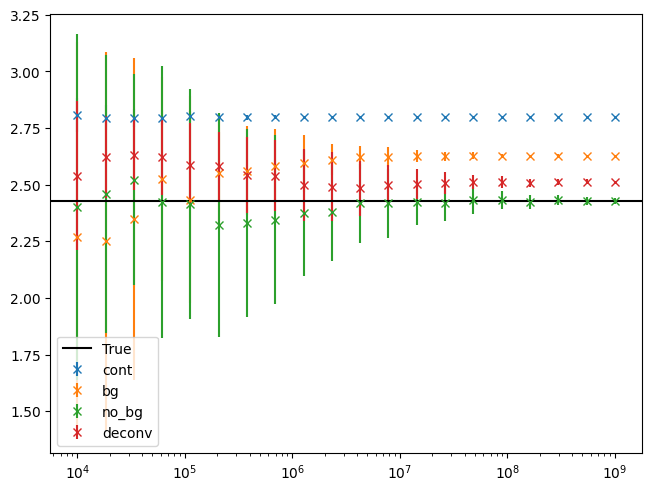

In [58]:
mean_dict = { 'cont' : np.mean(sol_cont_array,axis = 1)[:,1],
              'bg' : np.mean(sol_bg_array,axis = 1)[:,1],
              'no_bg' : np.mean(sol_array,axis = 1)[:,1],
              'deconv' : np.mean(sol_deconv_array,axis = 1)[:,1]
}
std_dict = { 'cont' : np.std(sol_cont_array,axis = 1)[:,1],
              'bg' : np.std(sol_bg_array,axis = 1)[:,1],
              'no_bg' : np.std(sol_array,axis = 1)[:,1],
              'deconv' : np.std(sol_deconv_array,axis = 1)[:,1]
}

# for k,v in mean_dict:
for  k,v in mean_dict.items():
    plt.errorbar(n_photon_arr, v,label = k,yerr = std_dict[k],fmt = 'x')
plt.axhline(tau[0],c='k',label = True)
plt.xscale('log')
plt.legend()

In [93]:
np.mean(sol_cont_array,axis = 1)

array([[  1.00266001,   2.79602138, 215.83794538],
       [  1.0023021 ,   2.7956702 , 144.82164997],
       [  1.00174001,   2.78784552, 131.88712809],
       [  1.00192785,   2.79371009,  92.72382803],
       [  1.00142629,   2.7896193 ,  81.84810335],
       [  1.00183941,   2.79255735,  77.90273846],
       [  1.00167098,   2.79156852,  77.29957361],
       [  1.00166966,   2.79222691,  75.98673958],
       [  1.00142004,   2.79016659,  77.79648946],
       [  1.00143542,   2.79036758,  77.11536009],
       [  1.00152693,   2.79078842,  76.90483343],
       [  1.00146689,   2.79040569,  76.9118707 ],
       [  1.00152639,   2.79079878,  76.6889532 ],
       [  1.00153971,   2.79089615,  76.53845015],
       [  1.00149022,   2.79054023,  76.8886264 ],
       [  1.00148946,   2.79056677,  76.82792916],
       [  1.00150163,   2.7907085 ,  76.76555296],
       [  1.0014867 ,   2.79056508,  76.85904085],
       [  1.00148535,   2.79055596,  76.85323077],
       [  1.00148838,   2.79060

In [72]:
np.mean(sol_array,axis = 1)

array([[0.39392367, 2.46740389, 7.91445071],
       [0.07030797, 2.57265483, 8.29438859],
       [0.0482442 , 2.50336999, 8.04063544],
       [0.07336473, 2.49494648, 7.15386701],
       [0.08238857, 2.43082439, 6.35622968],
       [0.0998812 , 2.39775556, 5.70664464],
       [0.15480275, 2.36424112, 4.54643403],
       [0.17882012, 2.36588249, 3.90555408],
       [0.25362003, 2.3510037 , 3.29516651],
       [0.276908  , 2.41646077, 3.22543367],
       [0.31002147, 2.3737535 , 3.11348443],
       [0.35748651, 2.39379472, 3.08164516],
       [0.39307682, 2.40360654, 3.06661149],
       [0.41207273, 2.42003172, 3.0744955 ],
       [0.42534502, 2.42322793, 3.07200317],
       [0.43280348, 2.41880579, 3.06169828],
       [0.45001339, 2.42882866, 3.06954795],
       [0.44236031, 2.42444366, 3.06421685],
       [0.4443031 , 2.42615996, 3.06510943],
       [0.44041467, 2.42378092, 3.06245532]])

In [207]:
z3 = np.array([0,p_d(1),p_d(2)])
discrete_solve(z3)

[0.4968791932689549, 2.4299292968749997, 3.069914308534873]

In [930]:
np.random.normal(scale = 0.001,size = (1, 2)).view(np.complex128)[0][0]

(-2.18847613609367e-05-0.0007525726889747615j)

In [884]:
EGFP.n_photon = int(1e3)
EGFP.repeat_sim(5000)
EGFP.phasor_solve_num()

 message: The solution converged.
 success: True
  status: 1
     fun: [ 1.110e-16 -5.551e-16 -1.665e-16]
       x: [ 4.975e-01  2.382e+00  3.125e+00]
  method: hybr
    nfev: 14
    fjac: [[-1.819e-07 -7.845e-01 -6.201e-01]
           [-1.164e-06 -6.201e-01  7.845e-01]
           [ 1.000e+00 -8.645e-07  8.002e-07]]
       r: [-1.646e-01  9.641e-02  1.220e-01 -9.696e-03  8.910e-03
            2.542e-08]
     qtf: [-6.975e-11 -2.218e-11  2.946e-16]

In [6]:
y_pure = exp2(EGFP.t,EGFP.amp[0],*EGFP.tau)
y_conv = np.convolve(y_pure,EGFP.ker,'full')[:380]
w,fft_pure = EGFP.phasor_fft(y_conv)
fft_pure[1]

(0.5733227893221606+0.48726799688720646j)

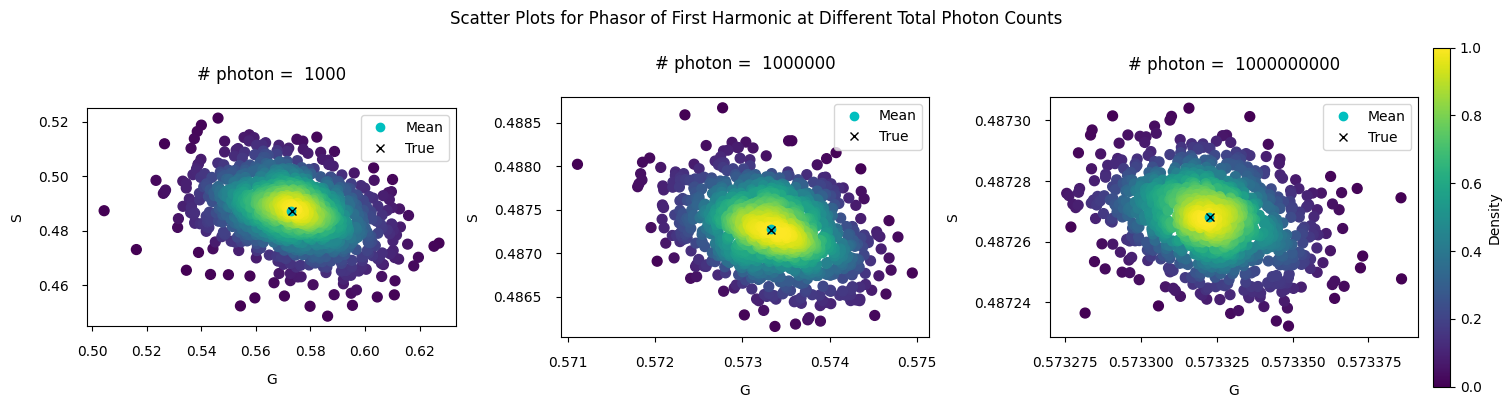

In [10]:
fig, ax = plt.subplots(1,3,figsize = (15,4))
n_harmonic= 1
fig.suptitle('Scatter Plots for Phasor of First Harmonic at Different Total Photon Counts')
for i in range(3):
    EGFP.n_photon = [int(1e3),int(1e6),int(1e9)][i]
    EGFP.repeat_sim(1000)   
    ax[i].set_title(f'# photon =  {EGFP.n_photon}',pad = 20 )
    mean = np.mean(EGFP.phasor_data[:,n_harmonic]) #mean of 1st harmonic, phasor_data
    x = EGFP.phasor_data[:,n_harmonic].real
    y = EGFP.phasor_data[:,n_harmonic].imag

    #calculate point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    z = (z - z.min()) / z.ptp() #scale z such that highest is 1, min. is 0
    #sort points by density
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    cax = ax[i].scatter(x, y, c=z, s=50,cmap = 'viridis')

    #cax = ax[i].hist2d(EGFP.phasor_data[:,n_harmonic].real,EGFP.phasor_data[:,n_harmonic].imag,bins = 20)
    if i ==2:
        cbar = fig.colorbar(cax,ax=ax[i], fraction=0.046, pad=0.04)
        cbar.set_label('Density')
    ax[i].set_xlabel('G',labelpad=10)
    ax[i].set_ylabel('S',labelpad=10)
    ax[i].set_aspect('equal')
    ax[i].plot(mean.real,mean.imag,'co',label = 'Mean')
    ax[i].plot(fft_pure[n_harmonic].real,fft_pure[n_harmonic].imag,'kx',label = 'True')
    ax[i].legend()
    ax[i].tick_params(axis='both', pad=10) 
    plt.locator_params(axis='y', nbins=5)
    plt.locator_params(axis='x', nbins=5)

In [32]:
fig.savefig('poster_fig/phasor_scatter.jpeg',dpi = 500)

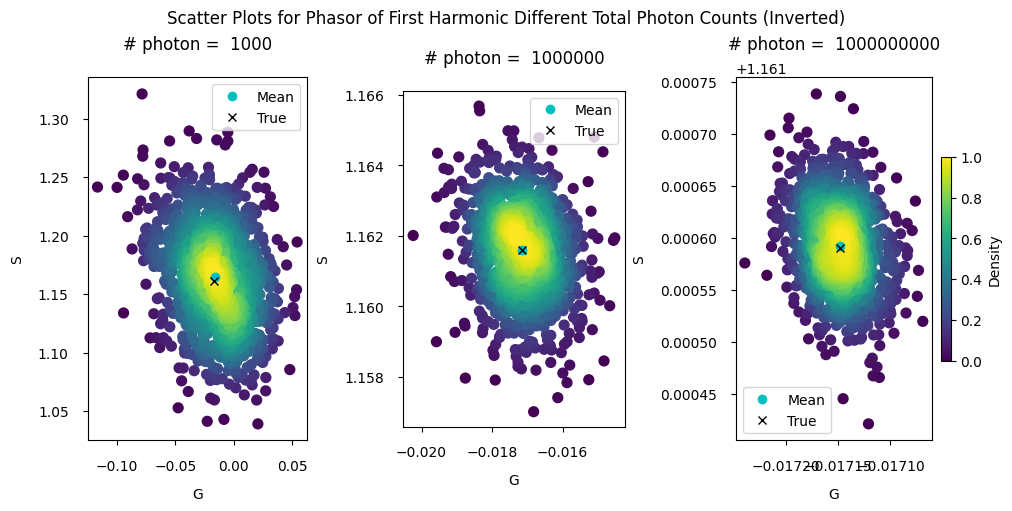

In [977]:
fig, ax = plt.subplots(1,3,figsize = (10,5))
n_harmonic= 1
fig.suptitle('Scatter Plots for Phasor of First Harmonic at Different Total Photon Counts (Inverted)')
for i in range(3):
    EGFP.n_photon = [int(1e3),int(1e6),int(1e9)][i]
    EGFP.repeat_sim(1000)   
    ax[i].set_title(f'# photon =  {EGFP.n_photon}',pad = 20 ) 
    p_inverted =inv( EGFP.phasor_data[:,n_harmonic])
    mean = np.mean(p_inverted)#mean of 1st harmonic, phasor_data
    x = p_inverted.real
    y = p_inverted.imag
    true_inverted = inv(fft_pure[n_harmonic])

    #calculate point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    z = (z - z.min()) / z.ptp() #scale z such that highest is 1, min. is 0
    #sort points by density
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    cax = ax[i].scatter(x, y, c=z, s=50,cmap = 'viridis')

    #cax = ax[i].hist2d(EGFP.phasor_data[:,n_harmonic].real,EGFP.phasor_data[:,n_harmonic].imag,bins = 20)
    if i ==2:
        cbar = fig.colorbar(cax,ax=ax[i], fraction=0.046, pad=0.04)
        cbar.set_label('Density')
    ax[i].set_xlabel('G',labelpad=10)
    ax[i].set_ylabel('S',labelpad=10)
    ax[i].set_aspect('equal')
    ax[i].plot(mean.real,mean.imag,'co',label = 'Mean')
    ax[i].plot(true_inverted.real,true_inverted.imag,'kx',label = 'True')
    ax[i].legend()
    ax[i].tick_params(axis='both', pad=10) 

In [970]:
fig.savefig('fig/phasor_scatter_2000_w1.pdf')

In [912]:
np.std(EGFP.phasor_data[:,1])

0.021096054044991274

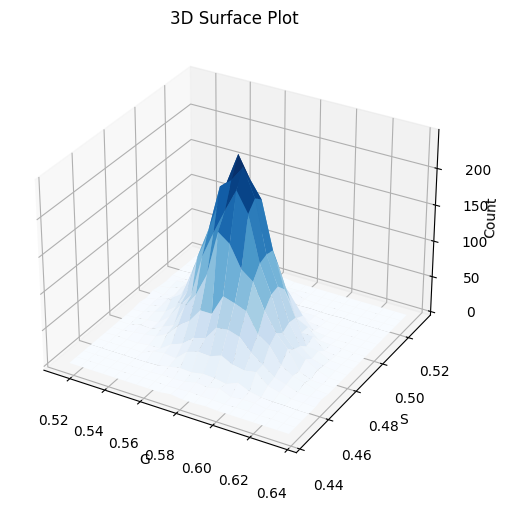

In [911]:
from mpl_toolkits.mplot3d import Axes3D
EGFP.n_photon = [int(1e3),int(1e6),int(1e9)][0]
EGFP.repeat_sim(10000)  
# Create the 2D histogram
hist, x_edges, y_edges = np.histogram2d(EGFP.phasor_data[:,1].real,EGFP.phasor_data[:,1].imag, bins=20)

# Get the bin centers
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2

# Create a meshgrid of the bin centers
X, Y = np.meshgrid(x_centers, y_centers)

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, Y, hist.T, cmap='Blues')

# Set labels and title
ax.set_xlabel('G')
ax.set_ylabel('S')
ax.set_zlabel('Count')
ax.set_title('3D Surface Plot')
ax.tick_params(axis='both', pad=10) 

# Display the plot
plt.show()

In [878]:
np.std(EGFP.phasor_data[:,1].imag)

0.011912507875404417

In [766]:
x_eq(0.5)

0.005062288575523932

In [130]:
result

1.9999999999999933

In [100]:
centre_inv = Point2D(1,0)
alpha= symbols('alpha',real = True)
x = symbols('x' ,real = True)
z = symbols('z0:%d' % (10))
y = symbols('y',real = True)
c = symbols('c') #centre of discrete cirle
slope = -cot(alpha)
#guess = Point2D(x[1],-cot(alpha)*x[1])
#p_given = Point2D(x[0],y[0]) #given bi-exp phasor
def harmonic_circ(n):
    '''Returns circle of nth harmonics where different lifetimes lie on
    Input: n -harmonic'''
    return Circle((0.5,-0.5*tan(alpha/2)),0.5/cos(alpha/2))

def phasor_ray(z,p):
    '''Ray drawn from guess phasor z to given bi-exp phasor p'''
    return Ray((z.real,z.imag),(p.real,p.imag))

def y_intercept_sym(z1,z3,z2):
    '''y-intercept of circle defined by z1,z2,z3,
       z1 lies on y axis (inverted mono exp component)
       z2 = 1
       z3 is the inverted bi exp phasor
       if z1.imag >z3.imag, y-intercept is below z1, hence the np.sign is used
       circle of the form z = (a+bt)/(c+dt) where t is a parameter'''
    a = z2*(z1-z3)
    b = z1*(z2-z3)
    c = z1-z3
    d = z2-z3
    centre = (a*conjugate(d)-b*conjugate(c))/(c*conjugate(d)-d*conjugate(c))
    y_sol = im(z1)-2*im(z2-centre)
    return y_sol

#def y_intercept_slope_sym(z1,z3,alpha):
    '''intercepts of circle with line of slope -cot(alpha), given circle defined by z1,z3,and z2 =1 '''
    #rotate the set up by alpha so the line becomes y intercept
    z2 = np.exp(-alpha*1j)
    z1 *=np.exp(-alpha*1j)
    z3 *=np.exp(-alpha*1j)
    y_sol = y_intercept(z1,z3,z2) #real value only (z4 = y_sol*1j)
    return  np.exp(alpha*1j)*y_sol*1j #rotate back

In [91]:
u = symbols('u1:%d' % (4),real = True) #e^-dt/tau1
f = symbols('f',real = True)
mono_sym = lambda n : [(1+u[i])/(1+u[i]*sp.exp(I*alpha*n)) for i in range(0,2)]
bi_sym = lambda n : f*mono_sym(n)[0] +(1-f)*mono_sym(n)[1]

In [123]:
c = 0.5-I*0.5*tan(alpha)
theta,phi=symbols('theta,phi',real = True)
x0,x1,x2,x3 = symbols('x0,x1,x2,x3 ',real = True)
y0,y1,y2,y3 = symbols('y0,y1,y2,y3 ',real = True)
intersect = [Eq(y-(x-1/2)*tan(2*theta+alpha)-1/2*tan(alpha),0),
            Eq(y-x-x0*tan(theta)-y0,0)]
sol = solve(intersect, (x, y))
z2 = sol[x]+I*sol[y]
simplify(re(inv(z2)))

0.5*((tan(alpha + 2.0*theta) - 1)*(2.0*x0*tan(theta) + 2.0*y0 - tan(alpha) - 1.0*tan(alpha + 2.0*theta) + 2.0) + 2.0*(x0*tan(theta)*tan(alpha + 2.0*theta) + y0*tan(alpha + 2.0*theta) - 0.5*tan(alpha) + 0.5*tan(alpha + 2.0*theta))**2 + 2.0*(x0*tan(theta) + y0 - 0.5*tan(alpha) - 0.5*tan(alpha + 2.0*theta) + 1.0)**2)/((x0*tan(theta)*tan(alpha + 2.0*theta) + y0*tan(alpha + 2.0*theta) - 0.5*tan(alpha) + 0.5*tan(alpha + 2.0*theta))**2 + (x0*tan(theta) + y0 - 0.5*tan(alpha) - 0.5*tan(alpha + 2.0*theta) + 1.0)**2)

In [812]:
inv(bi_sym(2))

1 + 1/(f*(u1 + 1)/(u1*exp(-2*I*alpha) + 1) + (1 - f)*(u2 + 1)/(u2*exp(-2*I*alpha) + 1) - 1)

In [ ]:
inv(bi_sym)

In [815]:
z3_inv = inv(z[3])
y_intercept_sym((x[1]-x[1]*cot(alpha)*I),inv(bi_sym(1)),1)

-x1*cot(alpha) + 2*((-x1*cot(alpha) - (-f*u1*(u1 + 1)*sin(alpha)/(u1**2*sin(alpha)**2 + (u1*cos(alpha) + 1)**2) - u2*(1 - f)*(u2 + 1)*sin(alpha)/(u2**2*sin(alpha)**2 + (u2*cos(alpha) + 1)**2))/((f*u1*(u1 + 1)*sin(alpha)/(u1**2*sin(alpha)**2 + (u1*cos(alpha) + 1)**2) + u2*(1 - f)*(u2 + 1)*sin(alpha)/(u2**2*sin(alpha)**2 + (u2*cos(alpha) + 1)**2))**2 + (f*(u1 + 1)*(u1*cos(alpha) + 1)/(u1**2*sin(alpha)**2 + (u1*cos(alpha) + 1)**2) + (1 - f)*(u2 + 1)*(u2*cos(alpha) + 1)/(u2**2*sin(alpha)**2 + (u2*cos(alpha) + 1)**2) - 1)**2))*(f*u1*(u1 + 1)*sin(alpha)/(u1**2*sin(alpha)**2 + (u1*cos(alpha) + 1)**2) + u2*(1 - f)*(u2 + 1)*sin(alpha)/(u2**2*sin(alpha)**2 + (u2*cos(alpha) + 1)**2))/((-f*u1*(u1 + 1)*sin(alpha)/(u1**2*sin(alpha)**2 + (u1*cos(alpha) + 1)**2) - u2*(1 - f)*(u2 + 1)*sin(alpha)/(u2**2*sin(alpha)**2 + (u2*cos(alpha) + 1)**2))**2 + (f*(u1 + 1)*(u1*cos(alpha) + 1)/(u1**2*sin(alpha)**2 + (u1*cos(alpha) + 1)**2) + (1 - f)*(u2 + 1)*(u2*cos(alpha) + 1)/(u2**2*sin(alpha)**2 + (u2*cos(alpha) +

In [777]:
Circle(centre_inv,p_given,guess)

Undecidable: 
Cannot determine if Point2D(-y0, x0 - 1) is a scalar multiple of
Point2D(x1/tan(alpha) + y0, -x0 + x1)

In [137]:
a = np.exp(-dt/tau)
def z(n):
    return (1+a)/(1+a*np.exp(1j*n*np.pi/N))
p1 = 0.35+0.16j
p2 = 0.25+0.008j
p = [p1,p2]
def z2(n):
    '''Return z2 for given harmonic'''
    z2 = intersection(harmonic_circ(n),phasor_ray(z(n),p[n-1]))[0].coordinates
    return z2[0]+1j*z2[1]
    

In [138]:
intersection(harmonic_circ(2),phasor_ray(z(2),p[2-1]))[0].coordinates

(12668928146697458581149947214673993512056737/10990916146227808512338131395890000000000000 - 226649235638391*sqrt(23272858502612877813499040969360811714832961960459414278353763641989317233791489)/1152948455874774170327956596802799716575470000000000000,
 -94571119618349517916946188231557916551821707/109909161462278085123381313958900000000000000 + 20787*sqrt(23272858502612877813499040969360811714832961960459414278353763641989317233791489)/109909161462278085123381313958900000000000000)

In [139]:
z2_inv = lambda n : conjugate(1/(z2(n)-1)+1)

In [140]:
def z2_diff(tau):
    '''Return z2_inv(1).real-z2_inv(2).real -> check z2_inv(1) = z2_inv(2)'''
    global a
    a = np.exp(-dt/tau)
    return float(re(z2_inv(1)-z2_inv(2)))

In [148]:
z2_diff(1)

-0.022806951667178155

In [133]:
-0.021410393939246854

-0.0018342873698134643

In [97]:
x = symbols('x')
z_2 = (1+x)/(1+x*exp(1j*2*pi*dt))

In [98]:
from scipy.optimize import root

In [101]:
nsolve(z2_diff,1)

AttributeError: 'function' object has no attribute 'free_symbols'

In [100]:
z(2)

array([1.00000175-0.00805002j])